In [1]:
import numpy as np
from matplotlib import pyplot as plt

from parcels import Variable, ScipyInteractionParticle, DiffusionUniformKh, ParticleSet, FieldSet, ScipyParticle
from parcels import NearestNeighborWithinRange, MergeWithNearestNeighbor, AsymmetricAttraction
from parcels import Timer
from parcels import logger
from tqdm import tqdm

INFO: Compiled ParcelsRandom ==> /tmp/parcels-1000/libparcels_random_63d78d22-53ce-49ad-917e-5a36f45d2dfd.so


In [2]:
logger.setLevel(27)

In [3]:
def benchmark(n_particles, density=1, interaction=True, attraction=False, n_sim=None):

    if n_sim is None:
        return np.mean([benchmark(n_particles, density, interaction, attraction, n_sim=1) for _ in range(10)])
    box_size = (n_particles/(800*density))**0.5
    X = np.random.uniform(-box_size, box_size, size=n_particles)
    Y = np.random.uniform(-box_size, box_size, size=n_particles)

    # Define a fieldset without flow
    fieldset = FieldSet.from_data({'U': 0, 'V': 0}, {'lon': 0, 'lat': 0}, mesh='flat')
    fieldset.add_constant_field("Kh_zonal", 0.0005, mesh="flat")
    fieldset.add_constant_field("Kh_meridional", 0.0005, mesh="flat")

    # Create custom InteractionParticle class with extra variables neirest_neighbor and mass
    class MergeParticle(ScipyInteractionParticle):
        nearest_neighbor = Variable('nearest_neighbor', dtype=np.int64, to_write=False)
        mass = Variable('mass', initial=1, dtype=np.float32)

    class AttractingParticle(ScipyInteractionParticle):
        attractor = Variable('attractor', dtype=np.bool_, to_write='once')


    kwargs = {"lon": X, "lat":Y, "fieldset": fieldset}
    if interaction:
        kwargs["interaction_distance"] = 0.05
        if attraction:
            attractor = np.zeros(n_particles, dtype=np.bool)
            attractor[:n_particles//10] = True
            kwargs["attractor"] = attractor
            kwargs["pclass"] = AttractingParticle
        else:
            kwargs["pclass"] = MergeParticle
    else:
        kwargs["interaction_distance"] = None
        kwargs["pclass"] = ScipyParticle
    pset = ParticleSet(**kwargs)  # note the interaction_distance argument here

    if interaction:
        if attraction:
            pyfunc_inter = pset.InteractionKernel(AsymmetricAttraction)
        else:
            pyfunc_inter = pset.InteractionKernel(NearestNeighborWithinRange) + MergeWithNearestNeighbor
    else:
        pyfunc_inter = None
    timer = Timer('interaction')
    pset.execute(pyfunc=DiffusionUniformKh, 
                 pyfunc_inter=pyfunc_inter,  # note the pyfunc_inter here
                 runtime=60, dt=1, output_file=None)
    timer.stop()
    return timer._t


In [4]:
all_n_particles = np.array([100, 500, 999, 1000, 2000, 3000, 5000, 10000, 20000, 30000, 50000, 100000])
bench_pp_merge = []
bench_no_pp = []
bench_pp_attraction = []

for n_particles in tqdm(all_n_particles):
    bench_pp_merge.append(benchmark(n_particles))

for n_particles in tqdm(all_n_particles):
    bench_no_pp.append(benchmark(n_particles, interaction=False))

for n_particles in tqdm(all_n_particles):
    bench_pp_attraction.append(benchmark(n_particles, attraction=True))
bench_pp_attraction = np.array(bench_pp_attraction)
    
bench_pp_merge = np.array(bench_pp_merge)
bench_no_pp = np.array(bench_no_pp)

100%|██████████| 12/12 [4:51:56<00:00, 1459.69s/it]


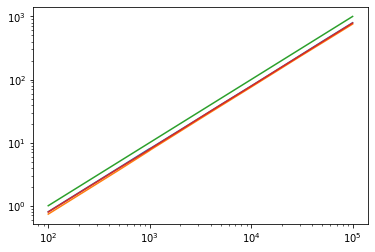

In [5]:
plt.xscale('log')
plt.yscale('log')
plt.plot(all_n_particles, bench_pp_merge)
plt.plot(all_n_particles, bench_no_pp)
plt.plot(all_n_particles, 1e-2*all_n_particles)
plt.plot(all_n_particles, bench_pp_attraction)
plt.show()

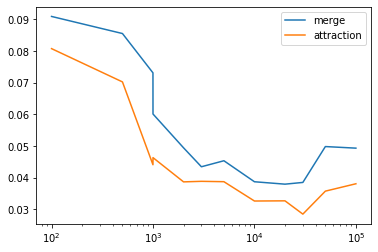

In [6]:
plt.xscale('log')
plt.plot(all_n_particles, (bench_pp_merge-bench_no_pp)/bench_no_pp, label="merge")
plt.plot(all_n_particles, (bench_pp_attraction-bench_no_pp)/bench_no_pp, label="attraction")
plt.legend()
plt.show()

In [5]:
all_densities = np.array([1, 2, 3, 5, 10, 20, 50])
bench_density_no_pp = []
bench_density_pp_merge = []
bench_density_pp_attraction = []

n_particles = 3000

for density in tqdm(all_densities):
    bench_density_no_pp.append(benchmark(n_particles, density=density, interaction=False))
for density in tqdm(all_densities):
    bench_density_pp_merge.append(benchmark(n_particles, density=density))
for density in tqdm(all_densities):
    bench_density_pp_attraction.append(benchmark(n_particles, density=density, interaction=True, attraction=True))

bench_density_pp_attraction = np.array(bench_density_pp_attraction)
bench_density_pp_merge = np.array(bench_density_pp_merge)
bench_density_no_pp = np.array(bench_density_no_pp)


100%|██████████| 7/7 [26:29<00:00, 227.11s/it]


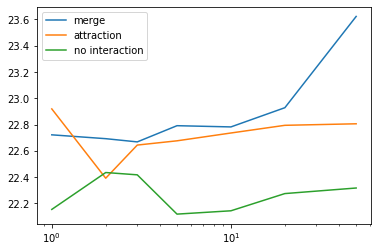

In [6]:
plt.plot(all_densities, bench_density_pp_merge, label="merge")
plt.plot(all_densities, bench_density_pp_attraction, label="attraction")
plt.plot(all_densities, bench_density_no_pp, label="no interaction")
plt.xscale('log')
plt.legend()
plt.show()